# Homework 4 - Hard coding

**Goal of the homework**: write important algorithms and functions from scratch.

In [ ]:
import warnings
from wordcloud import WordCloud
warnings.filterwarnings('ignore')
import pandas as pd
import sklearn
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import word_tokenize
from sklearn import decomposition
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
import string 
import matplotlib.pyplot as plt
import itertools 
from autocorrect import Speller 
import enchant
from scipy.spatial import distance
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import words
import collections
from sklearn.cluster import KMeans
from tqdm import tqdm
from kneed import KneeLocator
import time 

## 1. Hashing

In [ ]:
import math
import numpy as np

We will refer to hash.txt file.

We will implement our **hash** functions and the **HyperLogLog (HLL)** algorithm in order to know (or at least estimate) the cardinality of our dataset hash.txt.

#### 1.1 Let's implement our hash function from scratch

In [ ]:
def hash3(s, max_bit=32):
    max_value = 1 << max_bit
    l = len(s)
    result = 0
    for i in range(l):
        result += (s[i] ** (i+1))
        result %= max_value
    return result


#### 1.2 Using our hash function, let's implement a HyperLogLog structure

In [ ]:
class hyper_log_log2:
    def __init__(self, b=16, max_bit=32):
        self.b = b
        self.m = 2**b
        self.max_bit = max_bit
        #calculate the constant a_m 
        self.a_m = 0.7213 / (1+ 1.079 / self.m)
        self.collection_M=np.full(self.m,0)
        
        print("The error is equal to: ", (1.04/math.sqrt(self.m)))
        
    def insertion(self, s):
        #generate an hash value
        x = hash3(s)
        
        #split x (the hash value) into prefix and sufix
        #prefix:
        j= x >> (self.max_bit - self.b)
        
        #sufix:
        w = x&2**(self.max_bit - self.b) - 1
        
        
        self.collection_M[j]=max(self.collection_M[j], self.leftmost_binary_1_position(w,maxx_leftmost=self.max_bit-self.b))
        
        
    def leftmost_binary_1_position(self,binary_string,maxx_leftmost):
        numb=len(bin(binary_string)[2:])
        return maxx_leftmost-numb+1
    
    def cardinality(self):
        summ=np.sum(2.**(-self.collection_M))
    
        E = self.a_m * (self.m ** 2)/summ
        if E < 5.*self.m/2.:
            V = (self.collection_M==0).sum()
            if V==0:
                return E
            else:
                return self.m*np.log(self.m*1./V)
    
        return E 

#### 1.3 Read the dataset and add it to our HyperLogLog

In [26]:

hyperloglog=hyper_log_log2(16,32)
f = open(path, 'rb')


for line in f:
    line = line[:-1]
    hyperloglog.insertion(line)
    

f.close()

hyperloglog.cardinality()


The error is equal to:  0.0040625


124619088.0199604

## 2. Clustering

We play with a dataset gathering reviews of fine foods from Amazon.We focus on the reviews' plain text and try to cluster the products.

##### Cleaning of the text

We first need to load and clean the text, saving the result in a new .csv file the clean reviews for each id

In [ ]:
dataset = pd.read_csv(path)
dataset['ProfileName'].fillna("", inplace = True)
dataset['Summary'].fillna("", inplace = True)
dataset.set_index('Id', inplace = True)

In [ ]:
ps = PorterStemmer()
spell = Speller(lang='en')
tokenizer = nltk.RegexpTokenizer(r"\w+")
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
d = enchant.Dict("en_US")


def clean_text(text): 
    
    words = word_tokenize(text)
    filtered_words = []
    for word in words:
         
        if d.check(word):
            if word.lower() not in stop_words and word.isalpha() and word not in string.punctuation:
                filtered_words.append(lemmatizer.lemmatize((ps.stem(word)).lower()))
            
    return filtered_words

In [ ]:
l=[]
for i in list(dataset['Text']):
    #clean the text of each review
    l.append(' '.join((clean_text(i))))

In [ ]:
dataset['clean_Text']=l
dataset['clean_Text']=dataset['clean_Text'].fillna("", inplace = True)
dataset['clean_Text'].to_csv(path)

So finally we can extract the ***clean text of each review*** in a DataFrame variable called "***df_text***":

In [ ]:
df_text = pd.read_csv(path)
df_text['clean_Text'].fillna("", inplace = True)

##### How we represent our data:

To represent our data, we exploit TFIDF, which helps us to understand how important a word is to a document in a text, and it helps to reduce not informative features for our clustering task.

In [ ]:
vectorizer1 = TfidfVectorizer()  
tfidf = vectorizer1.fit_transform(list(df_text['clean_Text']))  

##### Resizing of the data

In order to reduce the dimensionality of the dataset, we use the SVD method, setting 750 as the desired dimensionality of output data.

In [ ]:
svd1=TruncatedSVD(n_components=750)
X_svd1=svd1.fit_transform(tfidf)

### 2.1 Implementation of the k-means clustering algorithm 

In [ ]:
def k_means(X,k,max_iter=400):
    
    if isinstance(X, pd.DataFrame):
        X = X.values
    
    #Pick indices of k random point without replacement
    idx = np.random.choice(len(X), k, replace=False)
    centroids = X[idx, :]
    
    #Calculate the class of each point using euclidean distance
    C = np.argmin(distance.cdist(X, centroids, 'euclidean'),axis=1)
    for _ in range(max_iter):
        centroids = np.vstack([X[C==i,:].mean(axis=0) for i in range(k)])
        t = np.argmin(distance.cdist(X, centroids, 'euclidean'),axis=1)
        
        #Stop when C matrix doesn't change
        if np.array_equal(C,t):
            break
            
        C = t
    
    # return an array containg class of each data point, and the centroids
    return C,centroids

### 2.2 Run the algorithm on the food data and compare k-means with k-means++

To choose k (the best number of clusters), we will use the elbow method:

So we choose 5 as the number of clusters, and we'll start the clustering calling our previous implemented function **k_means**:

In [ ]:
P,centroids=k_means(X_svd1,k=5)

### 2.3 Analyse the obtained clusters

##### Identify the kind of products

To identify the kind of products in the cluster using a WordCloud visualization, we implement a new function:

In [ ]:
def generate_wordclouds(X, X_tfidf, P, word_pos):
    d = enchant.Dict("en_US")
    y_pred = P
    clusters = set(y_pred)
    top_count = 100

    for cluster_id in clusters:
        
        # compute the total tfidf for each term in the cluster 
        tfidf = X_tfidf[y_pred == cluster_id]
        tfidf_sum = np.sum(tfidf, axis=0) 
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1) 
        top_indices = tfidf_sum.argsort()[-top_count:]
        
        term_weights = {word_pos[idx]: tfidf_sum[idx] for idx in top_indices}
        dictt = collections.OrderedDict()
        for key in term_weights.keys():
            text = word_tokenize(key)
            if (nltk.pos_tag(text)[0][1]=='NN'or (nltk.pos_tag(text)[0][1])=='NNS') and d.check(key) and (key in words.words()):
                dictt[key]=term_weights[key]
                
        wc = WordCloud(width=1200, height=800, background_color="white")
        wordcloud = wc.generate_from_frequencies(dictt)

        fig, ax = plt.subplots(figsize=(10, 6), dpi=80)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        fig.suptitle(f"Cluster {cluster_id}")
            
               
    return clusters

Now we should know the positions of the words:

In [ ]:
word_pos = {v: k for k, v in vectorizer1.vocabulary_.items()}

And finally see the results:

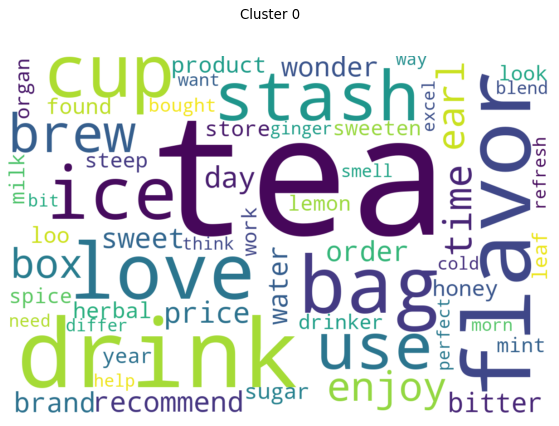

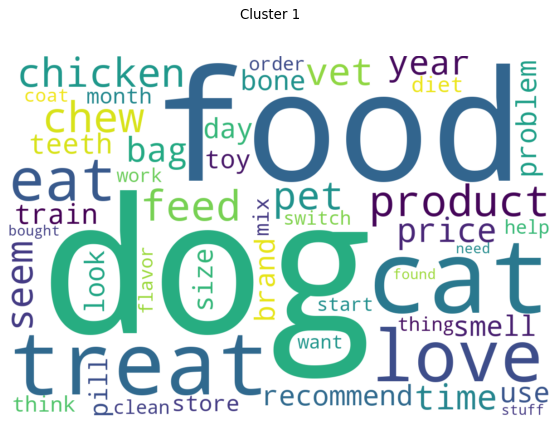

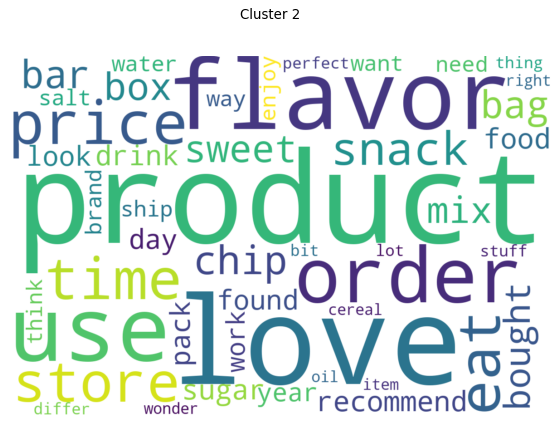

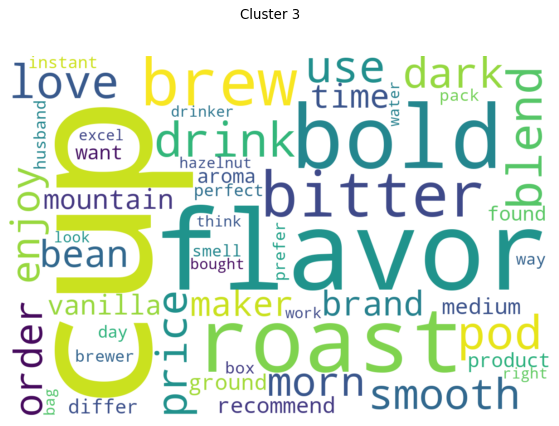

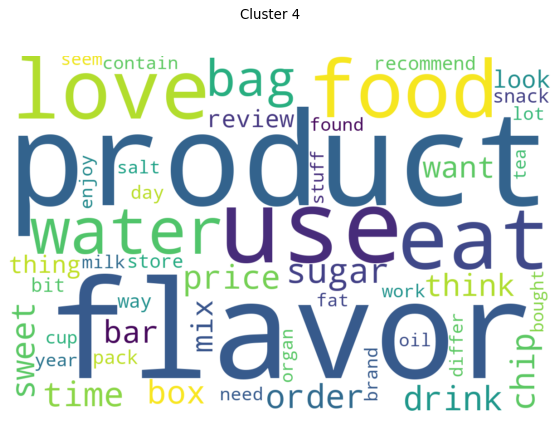

In [117]:
clusters = generate_wordclouds(X_svd1, tfidf, P, word_positions)

##### *Provide the number of product in each cluster*

In [12]:

for k in range(5):

    print('The number of products in the cluster '+str(k)+ ' is '+str(len(P[P==k])))
    

The number of products in the cluster 0 is 13598
The number of products in the cluster 1 is 51968
The number of products in the cluster 2 is 49879
The number of products in the cluster 3 is 374597
The number of products in the cluster 4 is 78412


###### *Compute the reviews' score distribution in each cluster*

In [14]:
dataset['Cluster'] = P

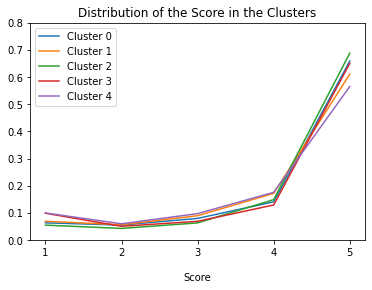

In [15]:

plt.figure()

for k in range(5):

    #for each cluster, we compute the relative frequency of reviews with a given score (from 1 to 5)
    perc = dataset[dataset.Cluster == k].groupby(dataset.Score).count().Cluster/len(dataset[dataset.Cluster == k])
    plt.plot(perc)

plt.xticks(range(1, 6, 1))
plt.ylim(0,.8)
plt.xlabel("\nScore")
plt.legend(labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.title("Distribution of the Score in the Clusters")

plt.show()


As we can see from these plots, the distribution of the Score in each Cluster is very similar: just a few reviews have score 1, even less have score 2 and then always more reviews have greater scores, until score 5, the most common one 

However, using the Analysis of Variance Test, we can test whether the means of the score's distributions are significantly different

In [16]:

#first of all, we need to define a list that will contain the different distributions of the score in the different clusters
distr = list()

for k in range(5):

  #for each cluster, we compute the frequency of reviews with a given score (from 1 to 5)
  distr.append(dataset[dataset.Cluster == k].groupby(dataset.Score).count().Cluster)
    

In [19]:

#now we can use ANOVA Test
from scipy.stats import f_oneway

stat, p = f_oneway(*distr)
print('pvalue = '+str(p))

if p > 0.05:
    print('The differences between the means are NOT statistically significant')
else:
    print('The differences between some of the means ARE statistically significant')


pvalue = 0.09876721296694035
The differences between the means are NOT statistically significant


###### *Get the number of unique users writing reviews in each cluster*

In [20]:

for k in range(5):

    print('The number of unique users in the cluster '+str(k)+ ' is '+str(len(set(dataset[dataset.Cluster==k].UserId))))
    

The number of unique users in the cluster 0 is 7065
The number of unique users in the cluster 1 is 24940
The number of unique users in the cluster 2 is 22842
The number of unique users in the cluster 3 is 195932
The number of unique users in the cluster 4 is 34598
